<h3>輸入原影像，經過壓縮轉換，再由轉換壓縮碼，還原成類原圖</h3>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
from glob import glob
import os
import numpy

In [3]:
import cv2

In [4]:
import tensorflow

In [5]:
import keras

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from matplotlib import cm

<h3>環境設置</h3>

In [7]:
image_path = 'images/full'
max_dim = (256, 256, 3)
enhance_flag = False

kernel = numpy.array([[-1, -1, -1], [-1, 11, -1], [-1, -1, -1]])

alpha = 0.6 # Contrast control (1.0-3.0)
beta = 2 # Brightness control (0-100)

<h3>載入魚影像檔</h3>

In [8]:
def read_image_file(my_image_file, enhanced=False):
    global max_dim, kernel, alpha, beta
    
    if not os.path.exists(my_image_file):
        return None
        
    _fish_image = cv2.imread(my_image_file, cv2.COLOR_BGR2RGB)
    if _fish_image is None:
        return None
    
    if enhanced:
        _fish_image = cv2.filter2D(_fish_image, -1, kernel)
        _fish_image = cv2.convertScaleAbs(_fish_image.copy(), alpha=alpha, beta=beta)

    _fish_image = cv2.resize(_fish_image.copy(), max_dim[:2])
    
    return _fish_image

In [9]:
def show_image(my_image):
    fig, ax = plt.subplots(dpi=120)
    ax.imshow(my_image)
    ax.axis('off')
    plt.show()

In [23]:
def benchmark(my_diff_image):
    diff = 0.0
    
    for i in range(max_dim[2]):
        diff += numpy.sum(numpy.square(my_diff_image))
        
    return diff**0.5

<h3>載入魚影像檔</h3>

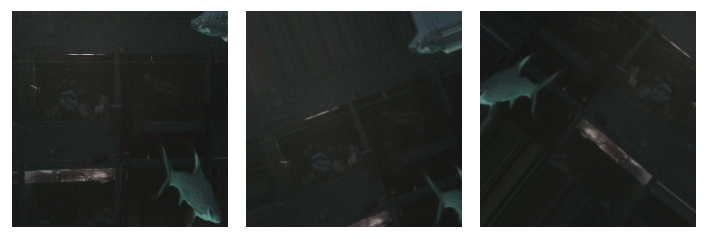

In [10]:
datagen = ImageDataGenerator(rotation_range=45,
                             width_shift_range=[0.1, 0.2],
                             height_shift_range=[0.1, 0.2],
                             horizontal_flip=True)

_fish_image = read_image_file('%s/F000223.jpg' % image_path, enhance_flag)

fig, ax = plt.subplots(dpi=120, ncols=3)

ax[0].imshow(_fish_image)
ax[0].axis('off')

_fish_img_data = img_to_array(_fish_image)    
_fish_img_data = numpy.expand_dims(_fish_img_data, 0)

it = datagen.flow(_fish_img_data, batch_size=1)

for i in range(1, 3):
    _batch = it.next()
    _generated_image = _batch[0].astype('uint8')
            
    ax[i].imshow(_generated_image, cmap='gray', interpolation='bicubic')
    ax[i].axis('off')
    
plt.tight_layout()
plt.show()

In [16]:
def load_data(image_path, train_ratio=0.8, enhanced=False):
    global max_dim

    datagen = ImageDataGenerator(rotation_range=45,
                                 width_shift_range=[0.1, 0.2],
                                 height_shift_range=[0.1, 0.2],
                                 horizontal_flip=True
    )
    
    image_files = glob('%s/F*.jpg' % image_path)

    my_images = []

    for image_file in image_files:
        _image_file = image_file.replace('\\', '/')
        
        _fish_image = read_image_file(_image_file, enhanced)
        if _fish_image is None:
            print('Not Found:', _image_file)
            continue
        
        my_images.append(numpy.reshape(_fish_image, max_dim))

        _fish_img_data = img_to_array(_fish_image)    
        _fish_img_data = numpy.expand_dims(_fish_img_data, 0)
        
        it = datagen.flow(_fish_img_data, batch_size=1)

        for i in range(10):
            _batch = it.next()
            _generated_image = _batch[0].astype('uint8')
            
            my_images.append(numpy.reshape(_generated_image, max_dim))

    my_images = numpy.array(my_images)
    numpy.random.shuffle(my_images)
    
    pos = int(my_images.shape[0] * train_ratio)
    return my_images[:pos], my_images[pos:]

In [22]:
x_train, x_test = load_data(image_path='images/full', train_ratio=0.8, enhanced=enhance_flag)

In [23]:
x_train.shape, x_test.shape

((20204, 256, 256, 3), (5052, 256, 256, 3))

<h3>將 0 ~ 255 值域，轉換為: 0 ~ 1</h3>

In [24]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

<h3>轉換 256x256 二維度為 65536 一維度</h3>

In [25]:
x_train = x_train.reshape((x_train.shape[0], numpy.prod(x_train.shape[1:])))
x_test = x_test.reshape((x_test.shape[0], numpy.prod(x_test.shape[1:])))

In [26]:
x_train.shape, x_test.shape

((20204, 196608), (5052, 196608))

<h3>參數設置</h3>
<p>$$壓縮率: \frac {65536}{64} = 1024$$</p>

In [14]:
encode_dimension = 12
encoding_dim = encode_dimension * encode_dimension

num_of_epoch = 512
num_of_batch_size = 8

<h3>建立模型</h3>

In [28]:
input_img = keras.Input(shape=(x_train.shape[1],), name='input')

In [29]:
encoded_512 = layers.Dense(512, name='encoded_512', activation='relu')(input_img)
encoded_384 = layers.Dense(384, name='encoded_384', activation='relu')(encoded_512)
encoded_256 = layers.Dense(256, name='encoded_256', activation='relu')(encoded_384)
encoded = layers.Dense(encoding_dim, name='latent', activation='relu')(encoded_256)

In [30]:
decoded_256 = layers.Dense(256, name='decoded_256', activation='relu')(encoded)
decoded_384 = layers.Dense(384, name='decoded_384', activation='relu')(decoded_256)
decoded_512 = layers.Dense(512, name='decoded_512', activation='relu')(decoded_384)
decoded = layers.Dense(x_train.shape[1], name='output', activation='sigmoid')(decoded_512)

In [31]:
autoencoder = keras.Model(input_img, decoded, name='autoencoder')

In [32]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 196608)]          0         
_________________________________________________________________
encoded_512 (Dense)          (None, 512)               100663808 
_________________________________________________________________
encoded_384 (Dense)          (None, 384)               196992    
_________________________________________________________________
encoded_256 (Dense)          (None, 256)               98560     
_________________________________________________________________
latent (Dense)               (None, 144)               37008     
_________________________________________________________________
decoded_256 (Dense)          (None, 256)               37120     
_________________________________________________________________
decoded_384 (Dense)          (None, 384)               

In [33]:
encoder = keras.Model(input_img, encoded)
encoded_input = keras.Input(shape=(encoding_dim,))

In [34]:
decoder_layer_256 = autoencoder.layers[-4]
decoder_layer_384 = autoencoder.layers[-3]
decoder_layer_512 = autoencoder.layers[-2]
decoder_layer = autoencoder.layers[-1]

decoder = keras.Model(encoded_input, 
                      decoder_layer(decoder_layer_512(
                          decoder_layer_384(
                          decoder_layer_256(encoded_input)))))

In [35]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

<h3>訓練模型</h3>

In [36]:
checkpointer = ModelCheckpoint(
    filepath='models/MLP-C-F-0-512-384-256-144.hdf5', 
    monitor="val_loss", verbose=1, 
    save_best_only=True, mode='auto'
)

earlyStop = EarlyStopping(monitor='val_loss', patience=50)

In [37]:
score = autoencoder.fit(x_train, x_train,
                        epochs=num_of_epoch,
                        batch_size=num_of_batch_size,
                        shuffle=True,
                        validation_data=(x_test, x_test),
                        callbacks=[checkpointer, earlyStop]
                       )

Epoch 1/512
2526/2526 [==============================] - ETA: 0s - loss: 0.4280
Epoch 00001: val_loss improved from inf to 0.42287, saving model to models/MLP-C-F-0-512-384-256-144.hdf5
2526/2526 [==============================] - 66s 26ms/step - loss: 0.4280 - val_loss: 0.4229
Epoch 2/512
2526/2526 [==============================] - ETA: 0s - loss: 0.4223
Epoch 00002: val_loss improved from 0.42287 to 0.42141, saving model to models/MLP-C-F-0-512-384-256-144.hdf5
2526/2526 [==============================] - 78s 31ms/step - loss: 0.4223 - val_loss: 0.4214
Epoch 3/512
2525/2526 [============================>.] - ETA: 0s - loss: 0.4219
Epoch 00003: val_loss improved from 0.42141 to 0.42134, saving model to models/MLP-C-F-0-512-384-256-144.hdf5
2526/2526 [==============================] - 78s 31ms/step - loss: 0.4219 - val_loss: 0.4213
Epoch 4/512
2525/2526 [============================>.] - ETA: 0s - loss: 0.4219
Epoch 00004: val_loss improved from 0.42134 to 0.42133, saving model to mod

Epoch 33/512
2526/2526 [==============================] - ETA: 0s - loss: 0.4216
Epoch 00033: val_loss did not improve from 0.42111
2526/2526 [==============================] - 62s 25ms/step - loss: 0.4216 - val_loss: 0.4211
Epoch 34/512
2524/2526 [============================>.] - ETA: 0s - loss: 0.4216
Epoch 00034: val_loss did not improve from 0.42111
2526/2526 [==============================] - 62s 25ms/step - loss: 0.4216 - val_loss: 0.4211
Epoch 35/512
2526/2526 [==============================] - ETA: 0s - loss: 0.4216
Epoch 00035: val_loss did not improve from 0.42111
2526/2526 [==============================] - 62s 25ms/step - loss: 0.4216 - val_loss: 0.4212
Epoch 36/512
2526/2526 [==============================] - ETA: 0s - loss: 0.4216
Epoch 00036: val_loss did not improve from 0.42111
2526/2526 [==============================] - 62s 25ms/step - loss: 0.4216 - val_loss: 0.4212
Epoch 37/512
2526/2526 [==============================] - ETA: 0s - loss: 0.4216
Epoch 00037: val_lo

Epoch 69/512
2524/2526 [============================>.] - ETA: 0s - loss: 0.4215
Epoch 00069: val_loss did not improve from 0.42110
2526/2526 [==============================] - 62s 25ms/step - loss: 0.4215 - val_loss: 0.4213
Epoch 70/512
2524/2526 [============================>.] - ETA: 0s - loss: 0.4215
Epoch 00070: val_loss did not improve from 0.42110
2526/2526 [==============================] - 62s 25ms/step - loss: 0.4215 - val_loss: 0.4211
Epoch 71/512
2526/2526 [==============================] - ETA: 0s - loss: 0.4215
Epoch 00071: val_loss did not improve from 0.42110
2526/2526 [==============================] - 62s 25ms/step - loss: 0.4215 - val_loss: 0.4211
Epoch 72/512
2526/2526 [==============================] - ETA: 0s - loss: 0.4215
Epoch 00072: val_loss improved from 0.42110 to 0.42109, saving model to models/MLP-C-F-0-512-384-256-144.hdf5
2526/2526 [==============================] - 78s 31ms/step - loss: 0.4215 - val_loss: 0.4211
Epoch 73/512
2524/2526 [=================

<h3>模型訓練績效</h3>

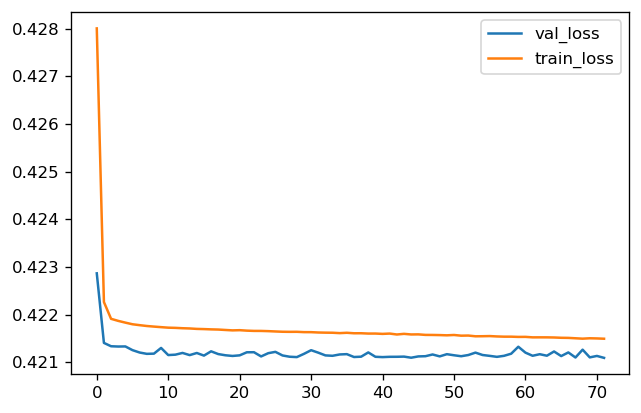

In [38]:
best_iteration = numpy.argmin(score.history['val_loss']) + 1

val_scores = score.history['val_loss'][0:best_iteration]
train_scores = score.history['loss'][0:best_iteration]

fig, ax = plt.subplots(dpi=120)

ax.plot(val_scores, label='val_loss')
ax.plot(train_scores, label='train_loss')

plt.legend(loc='upper right')
plt.show()

<h3>隨機顯示抽象圖</h3>

<h3>載入模型</h3>

In [30]:
my_model = keras.models.load_model('models/NLP-C-0-512-384-256-144.hdf5')
print(my_model.summary())

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 196608)]          0         
_________________________________________________________________
encoded_512 (Dense)          (None, 512)               100663808 
_________________________________________________________________
encoded_384 (Dense)          (None, 384)               196992    
_________________________________________________________________
encoded_256 (Dense)          (None, 256)               98560     
_________________________________________________________________
latent (Dense)               (None, 144)               37008     
_________________________________________________________________
decoded_256 (Dense)          (None, 256)               37120     
_________________________________________________________________
decoded_384 (Dense)          (None, 384)               

In [53]:
def load_validate_images(my_faint_image_files):
    my_faint_images = []

    for image_file in my_faint_image_files[:24]:
        _image_file = image_file.replace('\\', '/')

        _fish_image = read_image_file(_image_file, enhance_flag)

        my_faint_images.append(numpy.reshape(_fish_image, max_dim))

    my_faint_images = numpy.array(my_faint_images)

    my_faint_images = my_faint_images.astype('float32') / 255.

    _max_dim = max_dim[0] * max_dim[1] * max_dim[2]
    my_faint_images = numpy.reshape(my_faint_images, (my_faint_images.shape[0], _max_dim))

    print(my_faint_images.shape)
    
    return my_faint_images

In [55]:
def predict_validate_images(my_model, my_faint_images):
    faint_encoder = Model(inputs=my_model.input, outputs=my_model.get_layer('latent').output)

    faint_encoded_imgs = faint_encoder.predict(my_faint_images)
    faint_encoded_imgs = faint_encoded_imgs.reshape((len(faint_encoded_imgs), encode_dimension, encode_dimension, 1))

    faint_decoded_imgs = my_model.predict(my_faint_images)

    print(faint_encoded_imgs.shape, faint_decoded_imgs.shape)
    return faint_encoded_imgs, faint_decoded_imgs

In [76]:
def output_predicted_image(my_faint_image, my_faint_encoded_img, my_faint_decoded_img):
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(dpi=240, ncols=4)

    ax0.imshow(my_faint_image.reshape(max_dim))
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)

    faint_encoded_img_min = my_faint_encoded_img.min()
    faint_encoded_img_max = my_faint_encoded_img.max()
    faint_encoded_img_val = (my_faint_encoded_img - faint_encoded_img_min) / (faint_encoded_img_max - faint_encoded_img_min)

    ax1.imshow(faint_encoded_img_val.reshape(encode_dimension, encode_dimension), cmap=plt.cm.binary)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    ax2.imshow(my_faint_decoded_img.reshape(max_dim))
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

    faint_diff_image = my_faint_image - my_faint_decoded_img
    faint_diff_image_min = faint_diff_image.min()
    faint_diff_image_max = faint_diff_image.max()
    faint_diff_image_val = (faint_diff_image - faint_diff_image_min) / (faint_diff_image_max - faint_diff_image_min)

    ax3.imshow(faint_diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.show()

In [56]:
faint_image_files = glob('%s/F*.jpg' % 'images/objects/train')
numpy.random.shuffle(faint_image_files)

my_faint_images = load_validate_images(faint_image_files)

faint_encoded_imgs, faint_decoded_imgs = predict_validate_images(my_model, my_faint_images)

(24, 12, 12, 1) (24, 196608)


<h3>隨機顯示抽象圖與假圖</h3>

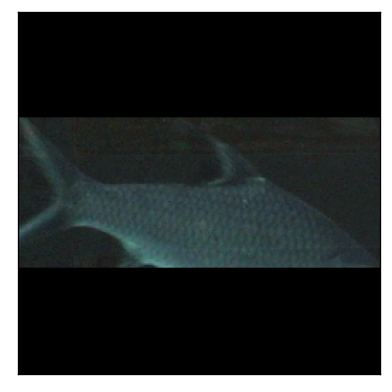

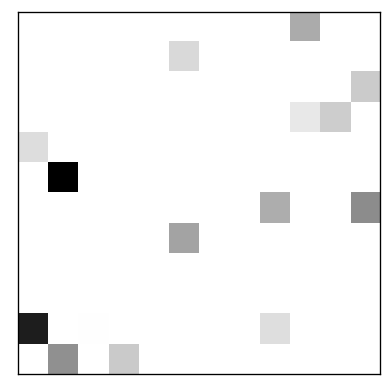

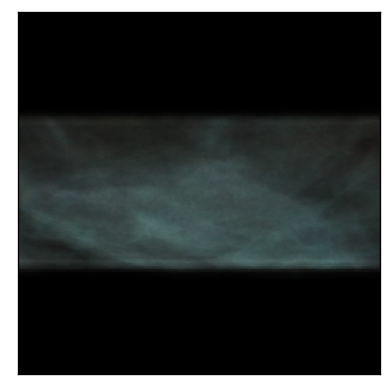

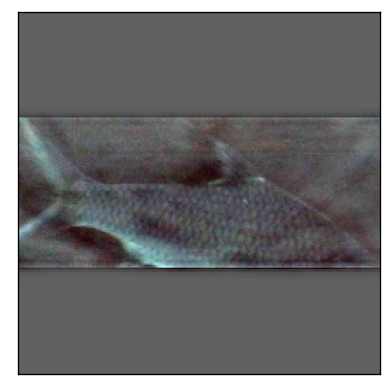

In [81]:
i = numpy.random.randint(0, faint_decoded_imgs.shape[0], 1)[0]

fig, ax = plt.subplots(dpi=120)

ax.imshow(my_faint_images[i].reshape(max_dim))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

fig, ax = plt.subplots(dpi=120)

encode_dimension = int(encoding_dim**0.5)
faint_encoded_imgs_min = faint_encoded_imgs[i].min()
faint_encoded_imgs_max = faint_encoded_imgs[i].max()
faint_encoded_imgs_val = (faint_encoded_imgs[i] - faint_encoded_imgs_min) / (faint_encoded_imgs_max - faint_encoded_imgs_min)

ax.imshow(faint_encoded_imgs_val.reshape(encode_dimension, encode_dimension), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

fig, ax = plt.subplots(dpi=120)

ax.imshow(faint_decoded_imgs[i].reshape(max_dim), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

fig, ax = plt.subplots(dpi=120)

faint_diff_image = my_faint_images[i] - faint_decoded_imgs[i]
faint_diff_image_min = faint_diff_image.min()
faint_diff_image_max = faint_diff_image.max()
faint_diff_image_val = (faint_diff_image - faint_diff_image_min) / (faint_diff_image_max - faint_diff_image_min)

ax.imshow(faint_diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

<h3>顯示原圖與假圖</h3>

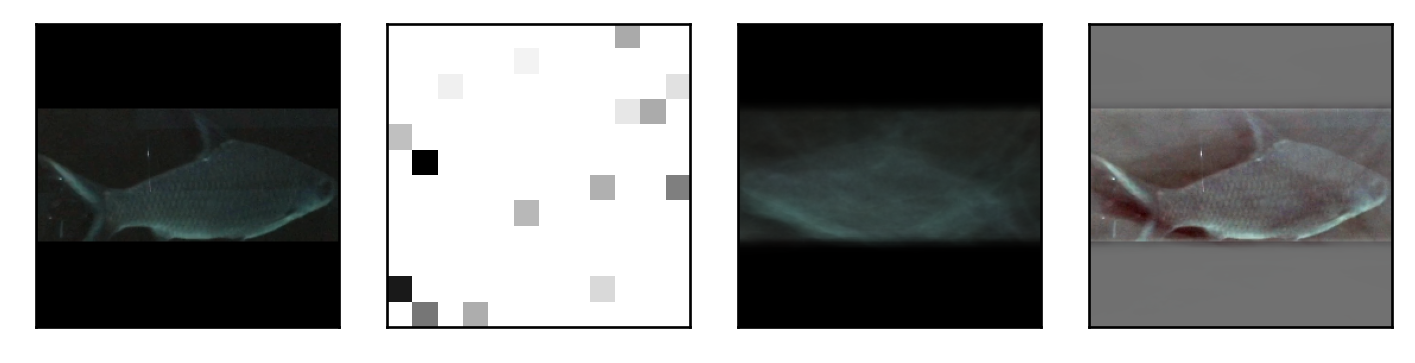

418.24846831757793

In [80]:
i = numpy.random.randint(0, faint_decoded_imgs.shape[0], 1)[0]
output_predicted_image(my_faint_images[i], faint_encoded_imgs[i], faint_decoded_imgs[i])
benchmark(faint_diff_image_val.reshape(max_dim))

<h3>隨機顯示抽象圖</h3>

In [65]:
faint_image_files = glob('%s/F*.jpg' % 'images/objects/faint')
numpy.random.shuffle(faint_image_files)

my_faint_images = my_faint_images = load_validate_images(faint_image_files)
faint_encoded_imgs, faint_decoded_imgs = predict_validate_images(my_model, my_faint_images)

(24, 196608)
(24, 12, 12, 1) (24, 196608)


In [66]:
def find_faint_file_pos(my_faint_images, my_image_id=None):
    pos = -1
    
    if my_image_id is None:
        pos = numpy.random.randint(0, my_faint_images.shape[0], 1)[0]
    else:
        for j in range(len(faint_image_files)):
            image_file = faint_image_files[j]
            if my_image_id in image_file:
                pos = j
                break
            
    if pos == -1:
        pos = numpy.random.randint(0, my_faint_images.shape[0], 1)[0]
        
    return pos

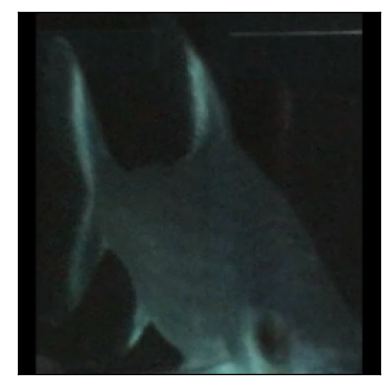

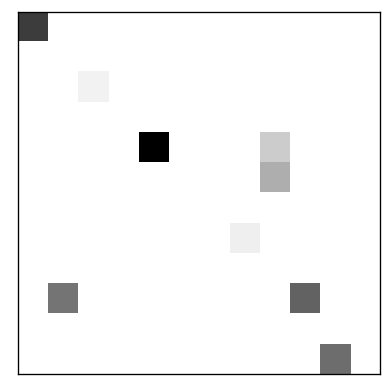

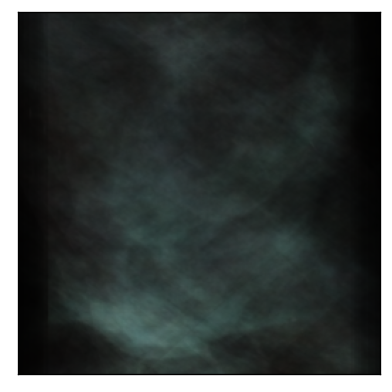

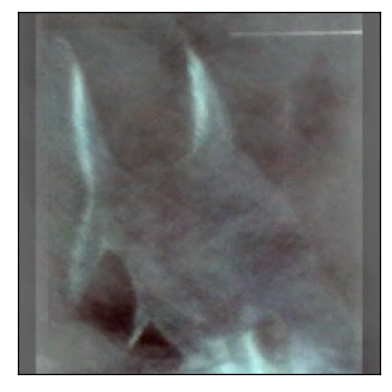

310.01891323353163

In [82]:
i = find_faint_file_pos(my_faint_images)

fig, ax = plt.subplots(dpi=120)

ax.imshow(my_faint_images[i].reshape(max_dim))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

fig, ax = plt.subplots(dpi=120)

faint_encoded_imgs_min = faint_encoded_imgs[i].min()
faint_encoded_imgs_max = faint_encoded_imgs[i].max()
faint_encoded_imgs_val = (faint_encoded_imgs[i] - faint_encoded_imgs_min) / (faint_encoded_imgs_max - faint_encoded_imgs_min)

ax.imshow(faint_encoded_imgs_val.reshape(encode_dimension, encode_dimension), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

fig, ax = plt.subplots(dpi=120)

ax.imshow(faint_decoded_imgs[i].reshape(max_dim), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

fig, ax = plt.subplots(dpi=120)

faint_diff_image = my_faint_images[i] - faint_decoded_imgs[i]
faint_diff_image_min = faint_diff_image.min()
faint_diff_image_max = faint_diff_image.max()
faint_diff_image_val = (faint_diff_image - faint_diff_image_min) / (faint_diff_image_max - faint_diff_image_min)

ax.imshow(faint_diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

benchmark(faint_diff_image_val.reshape(max_dim))

<h3>顯示原圖與假圖</h3>

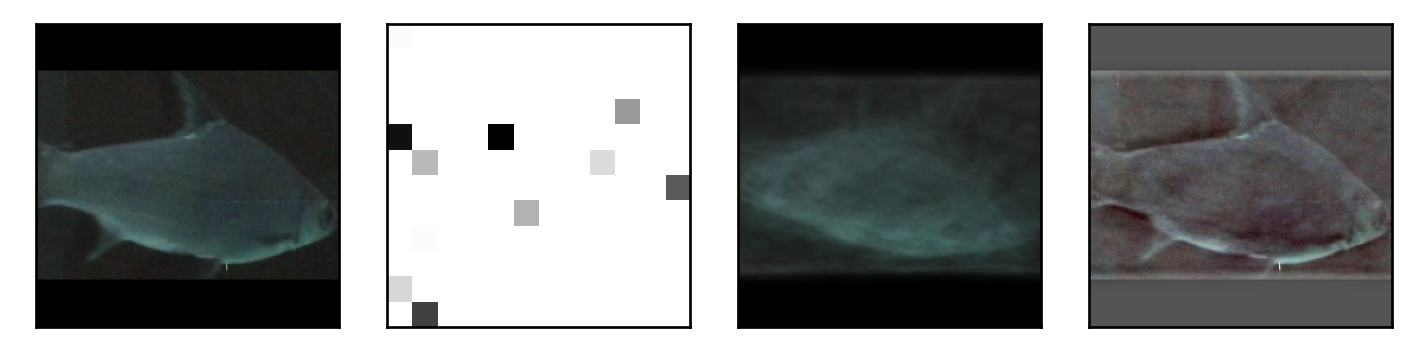

418.24846831757793

In [79]:
i = find_faint_file_pos(my_faint_images)
output_predicted_image(my_faint_images[i], faint_encoded_imgs[i], faint_decoded_imgs[i])
benchmark(faint_diff_image_val.reshape(max_dim))